# 手动实现前馈神经网络解决上述回归、二分类、多分类任务
+ 从训练时间、预测精度、Loss变化等角度分析实验结果(最好使用图表展示）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
import time

In [2]:
# 激活函数：ReLU
def relu(x):
    return np.maximum(0, x)

# ReLU的导数
def relu_deriv(x):
    return (x > 0).astype(float)

# 激活函数：Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Sigmoid的导数
def sigmoid_deriv(x):
    return x * (1 - x)

# 激活函数：Softmax
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_deriv(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

In [3]:
# 前馈神经网络类
class FeedforwardNN:
    def __init__(self, input_dim, hidden_dims, output_dim, activation='relu'):
        self.layers = len(hidden_dims) + 1
        self.activation = activation

        # 初始化权重和偏置
        self.weights = []
        self.biases = []
        dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(len(dims) - 1):
            self.weights.append(np.random.randn(dims[i], dims[i + 1]) * 0.01)
            self.biases.append(np.zeros((1, dims[i + 1])))

        if activation == 'relu':
            self.activation_func = relu
            self.activation_deriv = relu_deriv
        elif activation == 'sigmoid':
            self.activation_func = sigmoid
            self.activation_deriv = sigmoid_deriv

    def forward(self, X):
        self.z = []
        self.a = [X]

        for i in range(self.layers):
            z = np.dot(self.a[i], self.weights[i]) + self.biases[i]
            self.z.append(z)
            if i < self.layers - 1:
                self.a.append(self.activation_func(z))
            else:
                self.a.append(softmax(z) if self.weights[i].shape[1] > 1 else z)

        return self.a[-1]

    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        dz = self.a[-1] - y
        for i in reversed(range(self.layers)):
            dw = np.dot(self.a[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            if i > 0:
                dz = np.dot(dz, self.weights[i].T) * self.activation_deriv(self.a[i])
            self.weights[i] -= learning_rate * dw
            self.biases[i] -= learning_rate * db

    def train(self, X_train, y_train, X_test, y_test, epochs, learning_rate, batch_size):
        train_losses, test_losses, test_accuracies = [], [], []
        start_time = time.time()
    
        for epoch in range(epochs):
            # 随机打乱训练数据
            permutation = np.random.permutation(X_train.shape[0])
            X_train = X_train[permutation]
            y_train = y_train[permutation]
    
            # 批量训练
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                self.forward(X_batch)
                self.backward(X_batch, y_batch, learning_rate)
    
            # 记录训练损失
            y_pred_train = self.forward(X_train)
            train_loss = np.mean((y_pred_train - y_train) ** 2)  # 均方误差
            train_losses.append(train_loss)
    
            # 测试集评估
            y_pred_test = self.forward(X_test)
            test_loss = np.mean((y_pred_test - y_test) ** 2)  # 测试集 MSE 损失
            test_losses.append(test_loss)
    
            if y_train.shape[1] == 1 and len(np.unique(y_train)) == 2:  # 二分类任务
                y_pred_test_binary = (y_pred_test > 0.5).astype(int)
                test_accuracy = accuracy_score(y_test, y_pred_test_binary)
            elif self.weights[-1].shape[1] > 1:  # 多分类任务
                y_pred_test_binary = np.argmax(y_pred_test, axis=1)
                y_test_binary = np.argmax(y_test, axis=1)
                test_accuracy = accuracy_score(y_test_binary, y_pred_test_binary)
            else:
                test_accuracy = None  # 回归任务不适用准确率
    
            test_accuracies.append(test_accuracy)
    
            # 打印日志
            if test_accuracy is not None:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
            else:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
        training_time = time.time() - start_time
        return train_losses, test_losses, test_accuracies, training_time

In [4]:
# 加载回归数据
def load_regression_data(path):
    train_data = pd.read_csv(os.path.join(path, 'train_data.csv'))
    test_data = pd.read_csv(os.path.join(path, 'test_data.csv'))
    X_train = train_data.drop(columns='target').values
    y_train = train_data['target'].values.reshape(-1, 1)
    X_test = test_data.drop(columns='target').values
    y_test = test_data['target'].values.reshape(-1, 1)
    X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train = (X_train - X_mean) / X_std
    X_test = (X_test - X_mean) / X_std
    return X_train, y_train, X_test, y_test

In [5]:
# 加载二分类数据
def load_binary_data(path):
    train_data = pd.read_csv(os.path.join(path, 'train_data.csv'))
    test_data = pd.read_csv(os.path.join(path, 'test_data.csv'))
    X_train = train_data.drop(columns='target').values
    y_train = train_data['target'].values.reshape(-1, 1)
    X_test = test_data.drop(columns='target').values
    y_test = test_data['target'].values.reshape(-1, 1)
    X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train = (X_train - X_mean) / X_std
    X_test = (X_test - X_mean) / X_std
    return X_train, y_train, X_test, y_test

In [6]:
# 加载多分类数据
def load_mnist_data(path):
    from torchvision import datasets, transforms
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    X_train = train_data.data.numpy().reshape(-1, 28*28) / 255.0
    y_train = np.eye(10)[train_data.targets.numpy()]
    X_test = test_data.data.numpy().reshape(-1, 28*28) / 255.0
    y_test = np.eye(10)[test_data.targets.numpy()]
    return X_train, y_train, X_test, y_test

Epoch 1/30, Train Loss: 0.0157, Test Loss: 0.0155
Epoch 2/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 3/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 4/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 5/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 6/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 7/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 8/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 9/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 10/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 11/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 12/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 13/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 14/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 15/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 16/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 17/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 18/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 19/30, Train Loss: 0.0156, Test Loss: 0.0154
Epoch 20/30, Train Loss: 0.0156, Test Lo

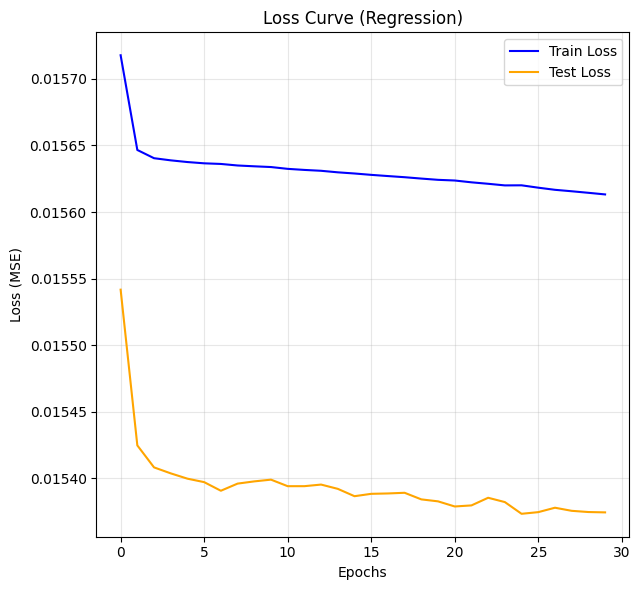

In [7]:
# 加载回归数据
X_train, y_train, X_test, y_test = load_regression_data('C:/Users/37623/jupyter_test/Lab2_Nerual_Network/dataset/regression_data')

# 定义模型
model = FeedforwardNN(input_dim=X_train.shape[1], hidden_dims=[128, 64], output_dim=1, activation='relu')

# 训练模型
train_losses, test_losses, test_accuracies, training_time = model.train(
    X_train, y_train, X_test, y_test, epochs=30, learning_rate=0.01, batch_size=64
)

# 绘制训练损失和测试损失曲线
plt.figure(figsize=(12, 6))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.title('Loss Curve (Regression)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(alpha=0.3)

# 打印日志
print(f"Final Test MSE (Regression): {test_losses[-1]:.4f}")

# 额外说明
plt.tight_layout()
plt.show()

Epoch 1/20, Train Loss: 0.2487, Test Loss: 0.2487, Test Accuracy: 0.5003
Epoch 2/20, Train Loss: 0.2444, Test Loss: 0.2444, Test Accuracy: 0.9683
Epoch 3/20, Train Loss: 0.1993, Test Loss: 0.1993, Test Accuracy: 1.0000
Epoch 4/20, Train Loss: 0.0043, Test Loss: 0.0043, Test Accuracy: 1.0000
Epoch 5/20, Train Loss: 0.0013, Test Loss: 0.0013, Test Accuracy: 1.0000
Epoch 6/20, Train Loss: 0.0013, Test Loss: 0.0013, Test Accuracy: 1.0000
Epoch 7/20, Train Loss: 0.0013, Test Loss: 0.0012, Test Accuracy: 1.0000
Epoch 8/20, Train Loss: 0.0012, Test Loss: 0.0012, Test Accuracy: 1.0000
Epoch 9/20, Train Loss: 0.0012, Test Loss: 0.0012, Test Accuracy: 1.0000
Epoch 10/20, Train Loss: 0.0012, Test Loss: 0.0012, Test Accuracy: 1.0000
Epoch 11/20, Train Loss: 0.0012, Test Loss: 0.0012, Test Accuracy: 1.0000
Epoch 12/20, Train Loss: 0.0012, Test Loss: 0.0012, Test Accuracy: 1.0000
Epoch 13/20, Train Loss: 0.0011, Test Loss: 0.0011, Test Accuracy: 1.0000
Epoch 14/20, Train Loss: 0.0011, Test Loss: 0.0

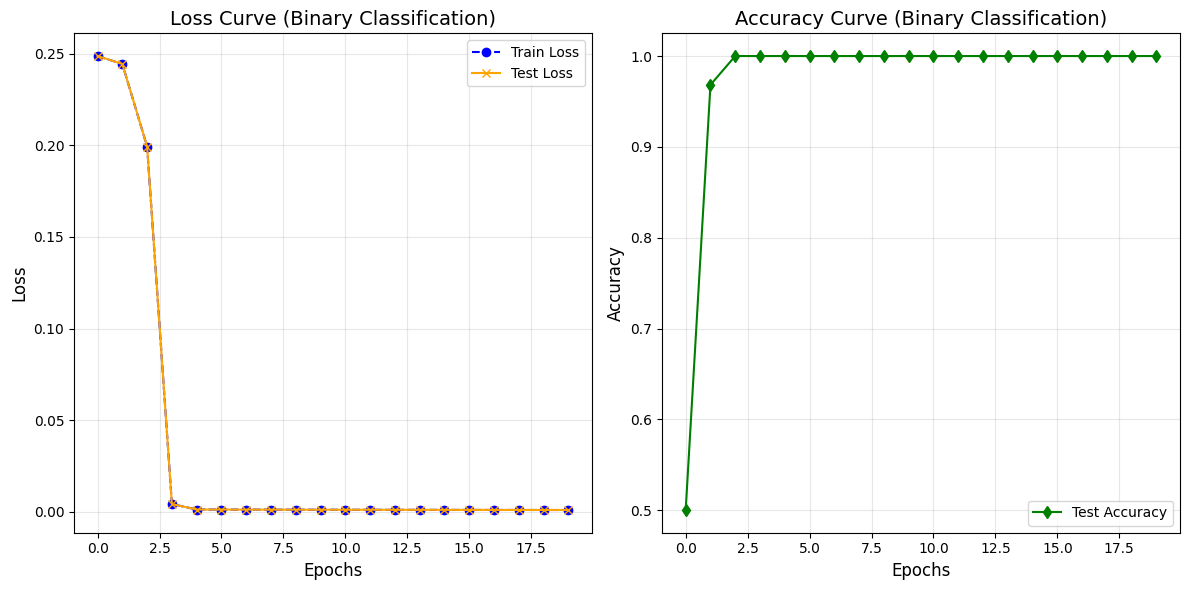

Final Test Accuracy (Binary Classification): 1.0000


In [7]:
# 加载数据
binary_data_path = r'C:/Users/37623/jupyter_test/Lab2_Nerual_Network/dataset/binary_data'
X_train, y_train, X_test, y_test = load_binary_data(binary_data_path)

# 数据标准化
X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# 数据增强
noise = np.random.normal(0, 0.1, X_train.shape)
X_train_augmented = np.vstack([X_train, X_train + noise])
y_train_augmented = np.vstack([y_train, y_train])

# 定义模型
model = FeedforwardNN(input_dim=X_train.shape[1], hidden_dims=[512, 256, 128], output_dim=1, activation='relu')

# 训练模型
train_losses, test_losses, test_accuracies, training_time = model.train(
    X_train_augmented, y_train_augmented, X_test, y_test, epochs=20, learning_rate=0.01, batch_size=64
)

# 绘制损失和准确率曲线
plt.figure(figsize=(12, 6))

# 绘制损失曲线
plt.subplot(1, 2, 1)  # 第一幅图
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='--', marker='o')
plt.plot(test_losses, label='Test Loss', color='orange', linestyle='-', marker='x')
plt.title('Loss Curve (Binary Classification)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# 绘制精度曲线
plt.subplot(1, 2, 2)  # 第二幅图
plt.plot(test_accuracies, label='Test Accuracy', color='green', linestyle='-', marker='d')
plt.title('Accuracy Curve (Binary Classification)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# 调整图像布局
plt.tight_layout()
plt.show()

# 打印最终测试集精度
print(f"Final Test Accuracy (Binary Classification): {test_accuracies[-1]:.4f}")

Epoch 1/100, Train Loss: 0.0899, Test Loss: 0.0899, Test Accuracy: 0.1135
Epoch 2/100, Train Loss: 0.0894, Test Loss: 0.0894, Test Accuracy: 0.2556
Epoch 3/100, Train Loss: 0.0673, Test Loss: 0.0669, Test Accuracy: 0.6089
Epoch 4/100, Train Loss: 0.0329, Test Loss: 0.0322, Test Accuracy: 0.7889
Epoch 5/100, Train Loss: 0.0258, Test Loss: 0.0252, Test Accuracy: 0.8366
Epoch 6/100, Train Loss: 0.0207, Test Loss: 0.0202, Test Accuracy: 0.8702
Epoch 7/100, Train Loss: 0.0182, Test Loss: 0.0179, Test Accuracy: 0.8827
Epoch 8/100, Train Loss: 0.0165, Test Loss: 0.0162, Test Accuracy: 0.8924
Epoch 9/100, Train Loss: 0.0153, Test Loss: 0.0151, Test Accuracy: 0.8987
Epoch 10/100, Train Loss: 0.0143, Test Loss: 0.0141, Test Accuracy: 0.9042
Epoch 11/100, Train Loss: 0.0135, Test Loss: 0.0132, Test Accuracy: 0.9115
Epoch 12/100, Train Loss: 0.0125, Test Loss: 0.0123, Test Accuracy: 0.9184
Epoch 13/100, Train Loss: 0.0118, Test Loss: 0.0115, Test Accuracy: 0.9243
Epoch 14/100, Train Loss: 0.0113, 

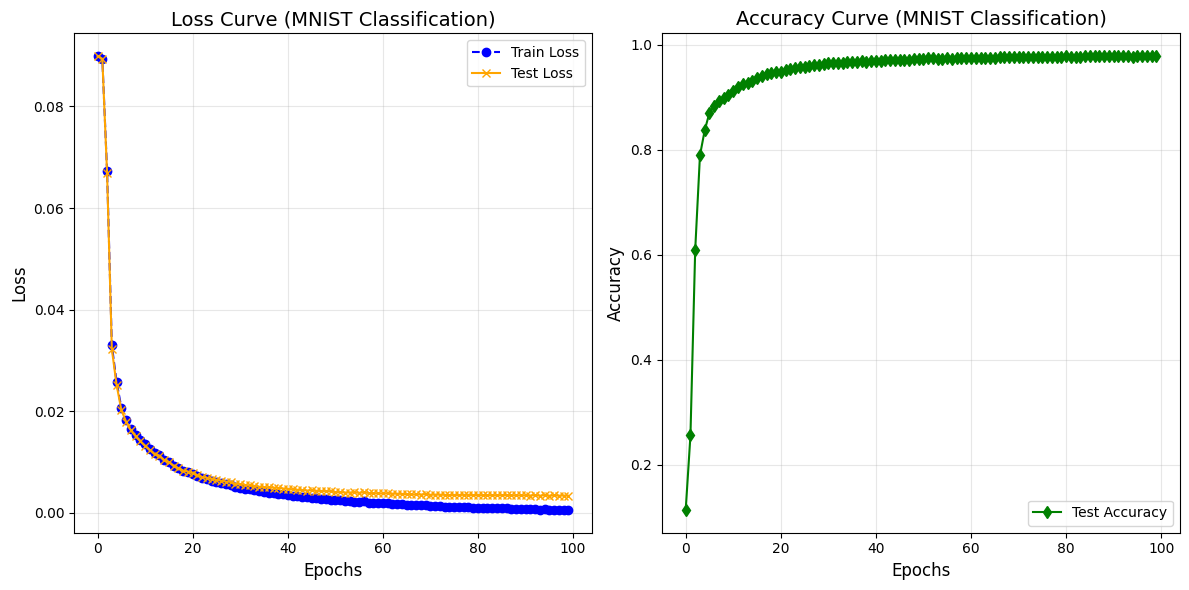

Final Test Accuracy (MNIST): 0.9781


In [13]:
# 加载 MNIST 数据
X_train, y_train, X_test, y_test = load_mnist_data('C:/Users/37623/jupyter_test/Lab2_Neural_Network/dataset/MNIST_data')

# 定义模型
model = FeedforwardNN(input_dim=X_train.shape[1], hidden_dims=[256, 128], output_dim=10, activation='relu')

# 训练模型
train_losses, test_losses, test_accuracies, training_time = model.train(X_train, y_train, X_test, y_test, epochs=100, learning_rate=0.01, batch_size=64)

# 绘制损失和准确率曲线
plt.figure(figsize=(12, 6))

# 绘制损失曲线
plt.subplot(1, 2, 1)  # 第一幅图
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='--', marker='o')
plt.plot(test_losses, label='Test Loss', color='orange', linestyle='-', marker='x')
plt.title('Loss Curve (MNIST Classification)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# 绘制精度曲线
plt.subplot(1, 2, 2)  # 第二幅图
plt.plot(test_accuracies, label='Test Accuracy', color='green', linestyle='-', marker='d')
plt.title('Accuracy Curve (MNIST Classification)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# 调整图像布局
plt.tight_layout()
plt.show()

# 打印最终测试集精度
print(f"Final Test Accuracy (MNIST): {test_accuracies[-1]:.4f}")

Epoch 1/100, Train Loss: 0.0887, Test Loss: 0.0887, Test Accuracy: 0.4849
Epoch 2/100, Train Loss: 0.0426, Test Loss: 0.0418, Test Accuracy: 0.7503
Epoch 3/100, Train Loss: 0.0251, Test Loss: 0.0245, Test Accuracy: 0.8448
Epoch 4/100, Train Loss: 0.0192, Test Loss: 0.0188, Test Accuracy: 0.8801
Epoch 5/100, Train Loss: 0.0170, Test Loss: 0.0165, Test Accuracy: 0.8917
Epoch 6/100, Train Loss: 0.0156, Test Loss: 0.0149, Test Accuracy: 0.9016
Epoch 7/100, Train Loss: 0.0147, Test Loss: 0.0143, Test Accuracy: 0.9052
Epoch 8/100, Train Loss: 0.0136, Test Loss: 0.0134, Test Accuracy: 0.9111
Epoch 9/100, Train Loss: 0.0128, Test Loss: 0.0124, Test Accuracy: 0.9176
Epoch 10/100, Train Loss: 0.0120, Test Loss: 0.0118, Test Accuracy: 0.9232
Epoch 11/100, Train Loss: 0.0112, Test Loss: 0.0110, Test Accuracy: 0.9279
Epoch 12/100, Train Loss: 0.0106, Test Loss: 0.0107, Test Accuracy: 0.9289
Epoch 13/100, Train Loss: 0.0099, Test Loss: 0.0099, Test Accuracy: 0.9358
Epoch 14/100, Train Loss: 0.0094, 

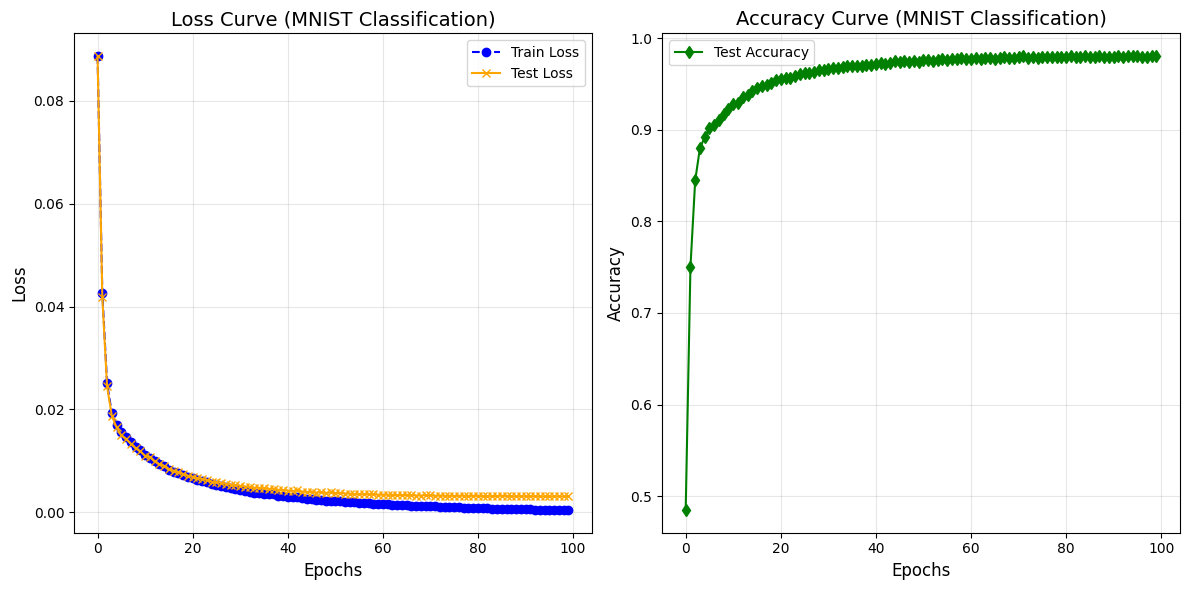

Final Test Accuracy (MNIST): 0.9804


In [8]:
# 加载 MNIST 数据
X_train, y_train, X_test, y_test = load_mnist_data('C:/Users/37623/jupyter_test/Lab2_Neural_Network/dataset/MNIST_data')

# 定义模型
model = FeedforwardNN(input_dim=X_train.shape[1], hidden_dims=[512, 512], output_dim=10, activation='relu')

# 训练模型
train_losses, test_losses, test_accuracies, training_time = model.train(X_train, y_train, X_test, y_test, epochs=100, learning_rate=0.01, batch_size=64)

# 绘制损失和准确率曲线
plt.figure(figsize=(12, 6))

# 绘制损失曲线
plt.subplot(1, 2, 1)  # 第一幅图
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='--', marker='o')
plt.plot(test_losses, label='Test Loss', color='orange', linestyle='-', marker='x')
plt.title('Loss Curve (MNIST Classification)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# 绘制精度曲线
plt.subplot(1, 2, 2)  # 第二幅图
plt.plot(test_accuracies, label='Test Accuracy', color='green', linestyle='-', marker='d')
plt.title('Accuracy Curve (MNIST Classification)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# 调整图像布局
plt.tight_layout()
plt.show()

# 打印最终测试集精度
print(f"Final Test Accuracy (MNIST): {test_accuracies[-1]:.4f}")